In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.graph_objects as go

import gmaps

### Store CSV into DataFrame

In [3]:
med_income_file = "Resources/household_median_income_2017.csv"
#imported first 52 rows, last row was NaN
med_income_df = pd.read_csv(med_income_file, nrows=52)
med_income_df.head()

,State,2017,2016,2015,2014,2013,2013.1,2012,2011,2010,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,United States,61372,60309,58476,55613,56479,54744,54569,54673,55520,...,52334,52615,53025,54621,55329,54390,53945,53309,51455,50511
1,Alabama,51113,48237,46053,43820,49876,43616,46490,46520,46120,...,42017,44323,42852,42607,40740,39852,40848,40965,39941,39007
2,Alaska,72231,77351,77717,70095,76387,64439,68080,62731,65178,...,71917,71791,71482,71686,68919,66133,68791,67138,75777,72912
3,Arizona,61125,58328,54060,51050,55453,53335,50320,53108,52839,...,51110,50420,54101,53309,54651,52811,55369,54600,52019,48280
4,Arkansas,48829,46894,44282,46560,41503,42075,41735,45114,43477,...,38594,41015,41248,41565,41025,40299,38971,40104,38019,35320


In [4]:
life_expect_file = "Resources/life_expectancy_2010-2015.csv"
#imported only rows 3-55 from csv as outside rows where just notes, not part of table
life_expect_df = pd.read_csv(life_expect_file, header=2, nrows=52)

life_expect_df.head()

,Location,Life Expectancy at Birth (years),Footnotes
0,United States,78.7,NaN
1,Alabama,75.5,NaN
2,Alaska,78.8,NaN
3,Arizona,79.9,NaN
4,Arkansas,76.0,NaN


### Create & Clean new Median Income dataframe with select columns

In [5]:
#select particular columns
new_med_income_df = med_income_df[['State','2010','2011','2012','2013','2014','2014', '2015']]

#drop duplicates (just in case)
new_med_income_df = new_med_income_df.drop_duplicates('State')

#create Median column
new_med_income_df['Median'] = new_med_income_df.mean(axis=1)
new_med_income_df.head()

,State,2010,2011,2012,2013,2014,2014,2015,Median
0,United States,55520,54673,54569,56479,55613,55613,58476,55849.000000
1,Alabama,46120,46520,46490,49876,43820,43820,46053,46099.857143
2,Alaska,65178,62731,68080,76387,70095,70095,77717,70040.428571
3,Arizona,52839,53108,50320,55453,51050,51050,54060,52554.285714
4,Arkansas,43477,45114,41735,41503,46560,46560,44282,44175.857143


In [6]:
#drop all specific year columns
new_med_income_df = new_med_income_df.drop(columns=['2010','2011','2012','2013','2014','2014', '2015'])

#rename columns
new_med_income_df = new_med_income_df.rename(columns={'State':'state','Median':'median_income'})

#set index to state
new_med_income_df = new_med_income_df.set_index('state')
new_med_income_df.head()

,median_income
state,
United States,55849.000000
Alabama,46099.857143
Alaska,70040.428571
Arizona,52554.285714
Arkansas,44175.857143


### Create & Clean new Life Expectancy dataframe with select columns

In [7]:
#select particular columns
new_life_expect_df = life_expect_df[['Location', 'Life Expectancy at Birth (years)']].copy()

#rename columns
new_life_expect_df = new_life_expect_df.rename(columns={'Location':'state',
                                                'Life Expectancy at Birth (years)':'life_expectancy'})

#set index to state
new_life_expect_df = new_life_expect_df.set_index('state')

new_life_expect_df.head()

,life_expectancy
state,
United States,78.7
Alabama,75.5
Alaska,78.8
Arizona,79.9
Arkansas,76.0


### Connect to local database

In [8]:
rds_connection_string = "postgres:1029@localhost:5432/life_income_db"
engine = create_engine(f'postgresql://{rds_connection_string}')

###Check for tables

In [12]:
engine.table_names()

['med_income', 'life_expect']

### Use pandas to load csv converted DataFrame into database
Commented out because data is already in database.

In [13]:
#new_med_income_df.to_sql(name='med_income', con=engine, if_exists='append', index=True)

In [14]:
#new_life_expect_df.to_sql(name='life_expect', con=engine, if_exists='append', index=True)

### Confirm data has been added by querying the tables

In [15]:
print('Median Income Table')
median_income=pd.read_sql_query('select * from med_income', con=engine).head()

Median Income Table


In [107]:
print('Life Expectancy Table')
pd.read_sql_query('select * from life_expect', con=engine).head()

Life Expectancy Table


,state,life_expectancy
0,United States,78.7
1,Alabama,75.5
2,Alaska,78.8
3,Arizona,79.9
4,Arkansas,76.0


### Join Tables

In [112]:
income_life_db=pd.read_sql_query('SELECT med_income.state, med_income.median_income, \
                    life_expect.life_expectancy \
                    FROM med_income LEFT JOIN life_expect \
                    ON med_income.state = life_expect.state;', con=engine)

income_life_db.dropna(inplace=True)
income_life_db.head()

,state,median_income,life_expectancy
0,United States,55849.000000,78.7
1,Alabama,46099.857143,75.5
2,Alaska,70040.428571,78.8
3,Arizona,52554.285714,79.9
4,Arkansas,44175.857143,76.0


# Correlation in between Median Income & Life Expectancy

In [113]:
correlation = income_life_db['median_income'].corr(income_life_db['life_expectancy'])
print(f"""there is a moderate positive correlation between life expectancy and median household income.
Correlation = {correlation}""")

there is a moderate positive correlation between life expectancy and median household income.
Correlation = 0.7811864031497228


In [114]:
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [115]:
x_values = income_life_db ['life_expectancy']
y_values = income_life_db ['median_income']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

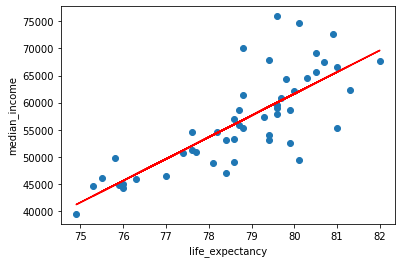

In [116]:
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
#plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('life_expectancy')
plt.ylabel('median_income')
plt.show()

In [117]:
#read state id df
state_id_df = pd.read_csv("Resources/statelatlong.csv")
state_id_df.head()

,state ID,latitude,longitude,state
0,AL,32.601011,-86.680736,Alabama
1,AK,61.302501,-158.775020,Alaska
2,AZ,34.168219,-111.930907,Arizona
3,AR,34.751928,-92.131378,Arkansas
4,CA,37.271875,-119.270415,California


In [118]:
#join both df
sid_inc_life_join=income_life_db.join(state_id_df.set_index('state'), on='state')

#sid_inc_life_join['median_income'] = '$' + (sid_inc_life_join['median_income'].round(0).astype(str)
sid_inc_life_join.head()

,state,median_income,life_expectancy,state ID,latitude,longitude
0,United States,55849.000000,78.7,NaN,NaN,NaN
1,Alabama,46099.857143,75.5,AL,32.601011,-86.680736
2,Alaska,70040.428571,78.8,AK,61.302501,-158.775020
3,Arizona,52554.285714,79.9,AZ,34.168219,-111.930907
4,Arkansas,44175.857143,76.0,AR,34.751928,-92.131378


In [121]:
#clean complete df
sid_inc_life_df_raw = sid_inc_life_join.drop([sid_inc_life_join.index[0] , sid_inc_life_join.index[9]])

sid_inc_life_df=sid_inc_life_df_raw.round({'median_income':0})
sid_inc_life_df.head()

,state,median_income,life_expectancy,state ID,latitude,longitude
1,Alabama,46100.0,75.5,AL,32.601011,-86.680736
2,Alaska,70040.0,78.8,AK,61.302501,-158.775020
3,Arizona,52554.0,79.9,AZ,34.168219,-111.930907
4,Arkansas,44176.0,76.0,AR,34.751928,-92.131378
5,California,62250.0,81.3,CA,37.271875,-119.270415


# The Top 3 Median Income States in 2010-2015

In [122]:
#sort median_income
#df.sort_values(by=['median_income'])
out = sid_inc_life_df.sort_values(by=['median_income'],ascending=False).head(3)
for s in list(list(out['state'])):
    print(s)

Maryland
New Hampshire
Connecticut


# The Bottom 3 Median Income States in 2010-2015

In [84]:
out = sid_inc_life_df.sort_values(by=['median_income']).head(3)
for s in list(list(out['state'])):
    print(s)

Mississippi
Arkansas
West Virginia


# The Top 3 Life Expectancy States in 2010-2015

In [85]:
out = sid_inc_life_df.sort_values(by=['life_expectancy'],ascending=False).head(3)

for s in list(list(out['state'])):
    print(s)

Hawaii
California
Minnesota


# The Bottom 3 Life Expectancy States in 2010-2015

In [86]:
out = sid_inc_life_df.sort_values(by=['life_expectancy']).head(3)

for s in list(list(out['state'])):
    print(s)

Mississippi
West Virginia
Alabama


In [24]:
import plotly.express as px

In [88]:
fig = px.choropleth(sid_inc_life_df,  # Input Pandas DataFrame
                    locations="state ID",  # DataFrame column with locations
                    color="median_income",  # DataFrame column with color values
                    color_continuous_scale=px.colors.diverging.RdYlGn,
                    #color_continuous_midpoint=avg_life_expectancy,
                    hover_name="state", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Median Income Across the States 2010-2015', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen

In [89]:
fig = px.choropleth(sid_inc_life_df,  # Input Pandas DataFrame
                    locations="state ID",  # DataFrame column with locations
                    color="life_expectancy",  # DataFrame column with color values
                    #color_continuous_scale = plotly.colors.sequentialYlOrBr
                    color_continuous_scale=px.colors.diverging.Spectral,
                    #color_continuous_midpoint=avg_life_expectancy,
                    hover_name ="state", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Life Expectancy Across the States 2010-2015', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
    #footnote_text = 'Data for Maine and Wisconsin are not available.'
)
fig.show()  # Output the plot to the screen

*Wisconsin and Maine 2010- 2015 life expectancy were not avaliable from the dataset.